# Lab 12 - Differential Equations

In this lab you will implement a simple solver for *ordinary differential
equations* (ODE) as well as a less verbose version of the `GaussNum`s that were
introduced in the lecture.

## Euler ODE Solver

In this first part you will implement your own, simple, ODE framwork (feel free
to make it a package;) in which you can easily specify different ODE solvers.
The API is heavily inspired by [`DifferentialEquations.jl`](https://diffeq.sciml.ai/stable/),
so if you ever need to use it, you will already have a feeling for how it works.

Like in the lecture, we want to be able to specify an ODE like below.

In [2]:
function lotkavolterra(x,θ)
    α, β, γ, δ = θ
    x₁, x₂ = x

    dx₁ = α*x₁ - β*x₁*x₂
    dx₂ = δ*x₁*x₂ - γ*x₂

    [dx₁, dx₂]
end

lotkavolterra (generic function with 1 method)

In the lecture we then solved it with a `solve` function that received all necessary
arguments to fully specify how the ODE should be solved. The number of necessary arguments
to `solve` can quickly become very large, so we will introduce a new API for `solve`
which will always take only two arguments: `solve(::ODEProblem, ::ODESolver)`.
The `solve` function will only do some book-keeping and call the solver until
the ODE is solved for the full `tspan`.

The `ODEProblem` will contain all necessary parameters to fully specify the ODE
that should be solved. In our case that is the function `f` that defines the
ODE itself, initial conditions `u0`, ODE parameters `θ`, and the time domain of
the ODE `tspan`:

In [3]:
struct ODEProblem{F,T<:Tuple{Number,Number},U<:AbstractVector,P<:AbstractVector}
    f::F
    tspan::T
    u0::U
    θ::P
end

The solvers will all be subtyping the abstract type `ODESolver`. The `Euler` solver
from the lecture will need one field `dt` which specifies its time step:

In [4]:
abstract type ODESolver end

struct Euler{T} <: ODESolver
    dt::T
end

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Overload the call-method of `Euler`
```julia
(solver::Euler)(prob::ODEProblem, u, t)
```
such that calling the solver with an `ODEProblem` will perform one step of the
Euler solver and return updated ODE varialbes `u1` and the corresponding
timestep `t1`.
</div>


<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [5]:
function (solver::Euler)(prob::ODEProblem, u, t)
    f, θ, dt  = prob.f, prob.θ, solver.dt
    (u + dt*f(u,θ), t+dt)
end

###

In [6]:
# define ODEProblem
θ = [0.1,0.2,0.3,0.2]
u0 = [1.0,1.0]
tspan = (0.,100.)
prob = ODEProblem(lotkavolterra,tspan,u0,θ)

# run one solver step
solver = Euler(0.2)
(u1,t1) = solver(prob,u0,0.)


([0.98, 0.98], 0.2)

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Implement the function `solve(::ODEProblem,::ODESolver)` which calls the solver
as many times as are necessary to solve the ODE for the full time domain.
`solve` should return a vector of timesteps and a corresponding matrix of
variables.
</div>

In [10]:
function solve(problem::ODEProblem,solver::ODESolver)
    t = problem.tspan[1]
    u = problem.u0
    us = [u]
    ts = [t]
    while t<=problem.tspan[2]
        (u, t) = solver(problem, u, t) 
        push!(us, u)
        push!(ts, t)
    end
    ts, us
end

solve (generic function with 1 method)

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [13]:
function solve(prob::ODEProblem, solver::ODESolver)
    t = prob.tspan[1]; u = prob.u0
    us = [u]; ts = [t]
    while t < prob.tspan[2]
        (u,t) = solver(prob, u, t)
        push!(us,u)
        push!(ts,t)
    end
    ts, reduce(hcat,us)
end

solve (generic function with 1 method)

###
You can load the true solution and compare it in a plot like below.  The file
that contains the correct solution is located here:
[`lotkadata.jld2`](https://github.com/JuliaTeachingCTU/Scientific-Programming-in-Julia/blob/master/docs/src/lecture_12/lotkadata.jld2).


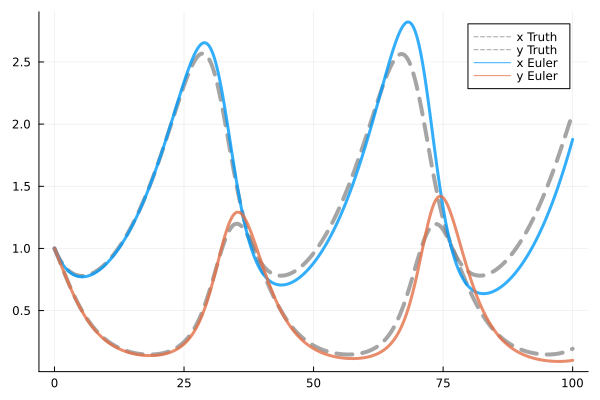

In [17]:
using JLD2
using Plots

true_data = load("lotkadata.jld2")

p1 = plot(true_data["t"], true_data["u"][1,:], lw=4, ls=:dash, alpha=0.7, color=:gray, label="x Truth")
plot!(p1, true_data["t"], true_data["u"][2,:], lw=4, ls=:dash, alpha=0.7, color=:gray, label="y Truth")

(t,X) = solve(prob, Euler(0.2))

plot!(p1,t,X[1,:], color=1, lw=3, alpha=0.8, label="x Euler")
plot!(p1,t,X[2,:], color=2, lw=3, alpha=0.8, label="y Euler")

As you can see in the plot above, the Euler method quickly becomes quite
inaccurate because we make a step in the direction of the tangent which inevitably
leads us away from the perfect solution as shown in the plot below.
<img src="euler.jpeg" align="center">

In the [homework] you will implement a Runge-Kutta solver to get a
much better accuracy with the same step size.


## Automating `GaussNum`s

Next you will implement your own uncertainty propagation. In the lecture you
have already seen the new number type that we need for this:


In [18]:
struct GaussNum{T<:Real} <: Real
    μ::T
    σ::T
end

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Overload the `±` (type: `\pm<tab>`) symbol to define `GaussNum`s like this: `2.0 ± 1.0`.
Additionally, overload the `show` function such that `GaussNum`s are printed
with the `±` as well.

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [19]:
±(x,y) = GaussNum(x,y)
Base.show(io::IO, x::GaussNum) = print(io, "$(x.μ) ± $(x.σ)")

###
Recall, that for a function $f(x)$ with $N$ inputs, the uncertainty $\sigma_f$
is defined by
\begin{equation}
\sigma_f = \sqrt{\sum_{i=1}^N \left( \frac{df}{dx_i}\sigma_i \right)^2}
\end{equation}
To make `GaussNum`s work for arithmetic operations we could
manually implement all desired functions as we started doing in the lecture.
With the autodiff package `Zygote` we can automate the generation of these
functions. In the next two exercises you will implement a macro `@register`
that takes a function and defines the corresponding uncertainty propagation
rule according to the equation above.



<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Implement a helper function `uncertain(f, args::GaussNum...)` which takes a
function `f` and its `args` and returns the resulting `GaussNum` with an
uncertainty defined by the equation above.

**Hint**:
You can compute the gradient of a function with Zygote, for example:
```julia
using Zygote;
f(x,y) = x*y;
Zygote.gradient(f, 2., 3.)
```
</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [22]:
using Zygote

function uncertain(f, args::GaussNum...)
    μs  = [x.μ for x in args]
    dfs = Zygote.gradient(f,μs...)
    σ   = map(zip(dfs,args)) do (df,x)
        (df * x.σ)^2
    end |> sum |> sqrt
    GaussNum(f(μs...), σ)
end

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1423


uncertain (generic function with 1 method)

###
Now you can propagate uncertainties through any function like this:

In [23]:
x1 = 2.0 ± 2.0
x2 = 2.0 ± 2.0
uncertain(*, x1, x2)

4.0 ± 5.656854249492381

You can verify the correctness of your implementation by comparing to the manual
implementation from the lecture.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
For convenience, implement the macro `@register` which will define the
uncertainty propagation rule for a given function. E.g. for the function `*`
the macro should generate code like below
    
```julia
Base.:*(args::GaussNum...) = uncertain(*, args...)
```
    
**Hint**:
If you run into trouble with module names of functions you can make use of
    
```julia
getmodule(f) = first(methods(f)).module
getmodule(*)

```
</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [24]:
getmodule(f) = first(methods(f)).module

function _register(func::Symbol)
    mod = getmodule(eval(func))
    :($(mod).$(func)(args::GaussNum...) = uncertain($func, args...))
end

function _register(funcs::Expr)
    Expr(:block, map(_register, funcs.args)...)
end

macro register(funcs)
    _register(funcs)
end

@register (macro with 1 method)

###
Lets register some arithmetic functions and see if they work

In [25]:
@register *
x1 * x2

4.0 ± 5.656854249492381

In [26]:
@register - +
x1 + x2

4.0 ± 2.8284271247461903

In [27]:
x1 - x2

0.0 ± 2.8284271247461903

To finalize the definition of our new `GaussNum` we can define conversion and
promotion rules such that we do not have to define things like
```julia
+(x::GaussNum, y::Real) = ...
+(x::Real, y::GaussNum) = ...
```

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Define `convert` and `promote_rule`s such that you can perform arithmetic operations
on `GaussNum`s and other `Real`s.

**Hint**:
When converting a normal number to a `GaussNum` you can set the standard deviation
to zero.
</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [28]:
Base.convert(::Type{T}, x::T) where T<:GaussNum = x
Base.convert(::Type{GaussNum{T}}, x::Number) where T = GaussNum(x,zero(T))
Base.promote_rule(::Type{GaussNum{T}}, ::Type{S}) where {T,S} = GaussNum{T}
Base.promote_rule(::Type{GaussNum{T}}, ::Type{GaussNum{T}}) where T = GaussNum{T}

###
You can test if everything works by adding/multiplying floats to `GuassNum`s.

In [29]:
1.0±1.0 + 2.0

3.0 ± 1.0

### Propagating Uncertainties through ODEs

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
With our newly defined `GaussNum` we can easily propagate uncertainties through
our ODE solvers without changing a single line of their code. Try it!
</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [30]:
θ = [0.1±0.001, 0.2, 0.3, 0.2]
u0 = [1.0±0.1, 1.0±0.1]
tspan = (0.,100.)
dt = 0.1
prob = ODEProblem(lotkavolterra,tspan,u0,θ)

t,X=solve(prob, Euler(0.1))

([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999  …  99.19999999999864, 99.29999999999863, 99.39999999999863, 99.49999999999862, 99.59999999999862, 99.69999999999861, 99.7999999999986, 99.8999999999986, 99.9999999999986, 100.09999999999859], GaussNum{Float64}[1.0 ± 0.1 0.99 ± 0.10004503985705639 … 2.00962692174768 ± 0.21113644544097507 2.0240144792168877 ± 0.21141809631075895; 1.0 ± 0.1 0.99 ± 0.10008496390567367 … 0.14203411803680374 ± 0.2658286647109277 0.1434818062439686 ± 0.2661634685328382])

###

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Create a plot that takes a `Vector{<:GaussNum}` and plots the mean surrounded
by the uncertainty.
    
Hint: `function uncertainplot(t, x::Vector{<:GaussNum})`

</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [31]:
mu(x::GaussNum) = x.μ
sig(x::GaussNum) = x.σ

sig (generic function with 1 method)

In [32]:
function uncertainplot(t, x::Vector{<:GaussNum})
    p = plot(
        t,
        mu.(x) .+ sig.(x),
        xlabel = "x",
        ylabel = "y",
        fill = (mu.(x) .- sig.(x), :lightgray, 0.5),
        linecolor = nothing,
        primary = false, # no legend entry
    )
    
    # add the data to the plots
    plot!(p, t, mu.(X[1,:])) 

    return p
end

uncertainplot (generic function with 1 method)

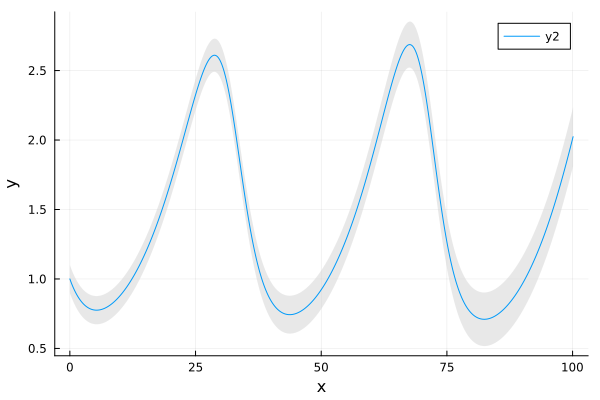

In [33]:
uncertainplot(t, X[1,:])

###
Unfortunately, with this approach, we would have to define things like `uncertainplot!`
by hand.
To make plotting `GaussNum`s more pleasant we can make use of the `@recipe`
macro from `Plots.jl`. It allows to define plot recipes for custom types
(without having to depend on Plots.jl). Additionally, it makes it easiert to
support all the different ways of creating plots (e.g. via `plot` or `plot!`,
and with support for all keyword args) without having to overload tons of
functions manually. If you want to read more about plot recipies in the docs
of [`RecipesBase.jl`](http://juliaplots.org/RecipesBase.jl/stable/).
An example of a recipe for vectors of `GaussNum`s could look like this:

In [34]:
@recipe function plot(ts::AbstractVector, xs::AbstractVector{<:GaussNum})
    # you can set a default value for an attribute with `-->`
    # and force an argument with `:=`
    μs = [x.μ for x in xs]
    σs = [x.σ for x in xs]
    @series begin
        :seriestype := :path
        # ignore series in legend and color cycling
        primary := false
        linecolor := nothing
        fillcolor := :lightgray
        fillalpha := 0.5
        fillrange := μs .- σs
        # ensure no markers are shown for the error band
        markershape := :none
        # return series data
        ts, μs .+ σs
    end
    ts, μs
end

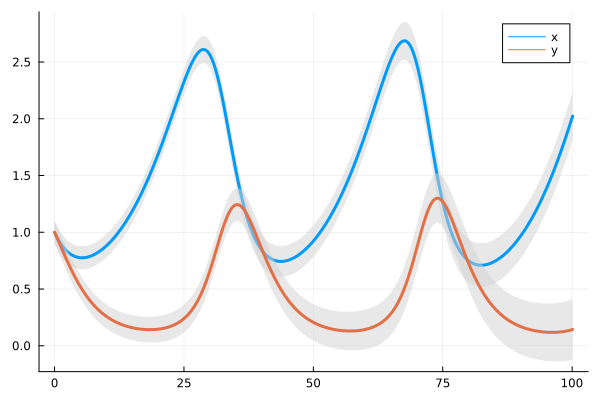

In [35]:
# now we can easily plot multiple things on to of each other
p1 = plot(t, X[1,:], label="x", lw=3)
plot!(p1, t, X[2,:], label="y", lw=3)